#  ESPNet: Efficient Spatial Pyramid of Dilated Convolutions for Semantic Segmentation

ESPNet is a fast and efficient convolutional neural network for semantic segmentation of high resolution images under resource constraints. ESPNet is based on a new convolutional module, efficient spatial pyramid (ESP), which is efficient in terms of computation, memory, and power. ESPNet is 22 times faster (on a standard GPU) and 180 times smaller than the state-of-the-art semantic segmentation network PSPNet, while its category-wise accuracy is only 8% less.

This notebook conrtains a full guide on how to use ESPNet-C version in Pytorch format, convert ESPNet to ONNX and OpenVINO IR format and run inference on them


## Notebook's Content

- [Prerequisites](#1)
- [Import necessary packages](#2)
- [Load ESPNEt-C model and test inference on it](#3)
- [Convert PyTorch model to ONNX](#4)
- [Convert ONNX model to OpenVINO IR](#5)
- [Run inference on ONNX and OpenVINO IR models](#6)
- [Visualize results from 3 models for comaprison](#7)

<a id='1'><a>
# Prerequisites

In [1]:
from pathlib import Path

# Clone ESPNet repository
if not Path('ESPNet').exists():
    !git clone https://github.com/sacmehta/ESPNet

# Navigate to the test folder which contains the python files we need to import, and the images data to test on
%cd ESPNet/test

D:\nouran\GSoC23\Prerequisite_Tasks\OpenVINO\openvino_notebooks\notebooks\204-espnet-segmentation\ESPNet\test


Cloning into 'ESPNet'...


In [2]:
import os

# Create folder for converted_models and results from inference on model in its 3 formats: pytorch, ONNX, OpenVINO IR
if not Path('converted_models').exists():
    os.makedirs('converted_models')
    
if not Path('data/pytorch_results').exists():
    os.makedirs('data/pytorch_results')
    
if not Path('data/onnx_results').exists():
    os.makedirs('data/onnx_results')
    
if not Path('data/openvino_ir_results').exists():
    os.makedirs('data/openvino_ir_results')

<a id='2'><a>
# Import Packages

In [3]:
import torch
import cv2 
import time
from argparse import Namespace
from typing import List
import glob
import numpy as np
import matplotlib.pyplot as plt

# Import ESPNet-C version and helper functions to run inference and produce colored segmented mask
from Model import ESPNet_Encoder
from VisualizeResults import evaluateModel, pallete, relabel

# Import OpenVINO needed packages
from openvino.runtime import serialize
from openvino.runtime import Core
from openvino.runtime import Model
from openvino.runtime import ConstOutput

<a id='3'><a>
# Load ESPNet-C model and run it

In [4]:
def load_espnet_c(p: int = 2, q: int = 8):
    '''
    Create the ESPNet_C model and load the pretrained weights
    
    Parameters:
    p (float): depth multiplier
    q (float): depth multiplier
    
    Return: 
    model (Model.ESPNet_Encoder): Pretrained ESPNet-C Model
    '''
    model = ESPNet_Encoder(p=p, q=q)
    model.load_state_dict(torch.load(f'../pretrained/encoder/espnet_p_{p}_q_{q}.pth', map_location=torch.device('cpu')))
    
    return model

In [5]:
# ESPNet-C is trained with p=2, q=3,5,8
# Change the variable 'q' to the value you want to use
p = 2
q = 8
espnet_c = load_espnet_c(p, q)

In [6]:
# Turn model to inference mode
espnet_c.eval()

# arguments control the inference process - Don't change
options = {'overlay':True, 'gpu':False, 'modelType':2, 'colored':True, 
           'savedir':'./pytorch_results', 'img_extn':'png', 'cityFormat':True}
args = Namespace(**options)

# ESPNet-C outputs the segmented mask 1/8th the original images dimensions
# So, an Upsampling layer is used to upsample the mask to the original dimensions
upsample = torch.nn.Upsample(scale_factor=8, mode='bilinear')
        
# Change directory to data folder to get image files for inference 
%cd data
image_list = glob.glob('*.png')

D:\nouran\GSoC23\Prerequisite_Tasks\OpenVINO\openvino_notebooks\notebooks\204-espnet-segmentation\ESPNet\test\data


In [7]:
# Run inference on the model
# The function saves the masks in the results folder
pytorch_start = time.time()
evaluateModel(args, espnet_c, upsample, image_list)
pytorch_end = time.time()

# Create a list of all images with results to visualize them
pytorch_imgs_list = sorted(image_list + glob.glob('pytorch_results/*'))

print(f"Inference time for PyTorch: {pytorch_end - pytorch_start} seconds")

D:\nouran\GSoC23\Prerequisite_Tasks\OpenVINO\openvino_notebooks\notebooks\204-espnet-segmentation\ESPNet\test\VisualizeResults.py:89: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_variable = Variable(img_tensor, volatile=True)


0
Inference time for PyTorch: 1.8970496654510498 seconds


In [8]:
# Visualize the results
def visualize_masks(imgs_list: List[Path]):
    '''
    Visualize the original image with the resulted masks
    
    Parameters:
    imgs_list (List[Path]): list of paths to images to be visualized
    
    Return: None
    '''
    plt.rcParams['figure.figsize'] = (17,7)
    
    # The titles match the order of images in the list
    # The order: first original image --> its masks --> then second original image --> its masks
    titles_dict = {1:'Original image', 2:'Colored mask', 3:'Mask', 4:'Overlayed mask',
                   5:'Original image', 6:'Colored mask', 7:'Mask', 8:'Overlayed mask'}
    
    for i,img_path in enumerate(imgs_list):
        img = cv2.imread(img_path)

        if i % 2 == 0:
            slot = i // 2 + 1
        else:
            slot = slot + 4

        plt.subplot(2,4,slot)
        plt.imshow(img)
        plt.title(titles_dict[slot])

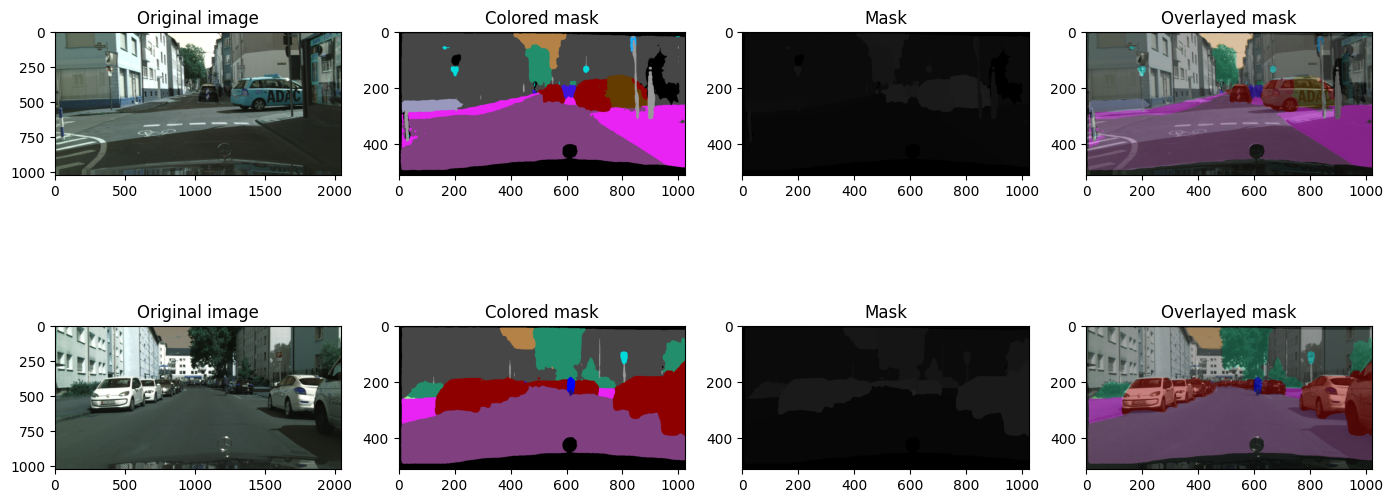

In [9]:
visualize_masks(pytorch_imgs_list)

<a id='4'><a>
# Convert PyTorch model to ONNX

In [10]:
# Create dummy input for conversion
# Set size of dummy_input to size of input to model 
dummy_input = torch.randn(1, 3, 512, 1024)

# Set path to saving the ONNX model
onnx_model_path = "../converted_models/espnet_c.onnx"

# Do the export 
torch.onnx.export(espnet_c,
                  dummy_input,
                  f=onnx_model_path,
                  verbose=True,
                  export_params=True)

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [11]:
# Load and compile ONNX model
ie = Core()
model_onnx = ie.read_model(model=onnx_model_path)
espnet_c_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

# Get output layer
output_layer_onnx = espnet_c_onnx.output(0)

<a id='5'><a>
# Convert ONNX model to OpenVINO IR

In [12]:
# Set path to saving the ONNX model
ir_model_path = "../converted_models/espnet_c_ir.xml"

# Do the conversion
serialize(model_onnx, xml_path="../converted_models/espnet_c_ir.xml")

In [13]:
# Load and compile OpenVINO IR model
model_ir = ie.read_model(model=ir_model_path)
espnet_c_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get output layer
output_layer_ir = espnet_c_ir.output(0)

<a id='6'><a>
# Run inference on ONNX and OpenVINO IR models

To test model work, we create inference pipeline similar to `VisualizeResults.py`. 
The pipeline consists from 
- Preprocessing step
- Inference of model 
- Post-processing to get colored masks.

### Preprocessing

Model input is tensor with shape `[1, 3, 512, 1024]` in `N, C, H, W` format, where
* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

Model expects images in RGB channels format and normalized in [0, 1] range.

In [14]:
def preprocess_image(img_orig: np.ndarray):
    '''
    Preprocess the images to the expected input format for ESPNet-C
    
    Parameters:
    img_orig (np.ndarray): the image to be preprocessed
    
    Return: 
    img_tensor (torch.tensor): The preprocessed image
    '''
    mean = [72.3923111, 82.90893555, 73.15840149]
    std = [45.3192215, 46.15289307, 44.91483307]
    
    img = np.copy(img_orig)

    img = img.astype(np.float32)
    for j in range(3):
        img[:, :, j] -= mean[j]
    for j in range(3):
        img[:, :, j] /= std[j]

    # resize the image to 1024x512x3
    img = cv2.resize(img, (1024, 512))
    img /= 255
    img = img.transpose((2, 0, 1))
    img_tensor = torch.from_numpy(img).contiguous().detach()
    img_tensor = torch.unsqueeze(img_tensor, 0)  # add a batch dimension
    
    return img_tensor


def predict_mask(image_path: Path, model: Model, output_layer: ConstOutput, args: Namespace, save_dir: Path):
    '''
    Do inference on the given model, predict the segmentation mask and postprocess the mask
    
    Parameters:
    image_path (Path): path to image which used for inference
    model (Model): the model used for inference --> can be ONNX, OpenVINO IR
    output_layer (ConstOutput): output layer for converted model format --> ONNX, OpenVINO IR
    args (Namespace): rguments control the inference process
    save_dir (Path): directory to save results
    
    Return:
    classMap_numpy (np.ndarray): Original mask
    classMap_numpy_color (np.ndarray): Colored mask
    overlayed (np.ndarray): overlayed mask
    '''

    img_orig = cv2.imread(image_path)
    
    # Preprocess the image
    preprocessed_img = preprocess_image(img_orig)
    
    if args.overlay:
        img_orig = cv2.resize(img_orig, (1024, 512))
        
    if args.gpu:
        preprocessed_img = preprocessed_img.cuda()
        
    img_out = model([preprocessed_img])[output_layer]

    if args.modelType == 2:
        img_out = upsample(torch.from_numpy(img_out))

    # Postprocessing: Generate colored and overlayed masks
    classMap_numpy = img_out[0].max(0)[1].byte().cpu().data.numpy()

    if args.colored:
        classMap_numpy_color = np.zeros((preprocessed_img[0].shape[1], preprocessed_img[0].shape[2], preprocessed_img[0].shape[0]), dtype=np.uint8)
        for idx in range(len(pallete)):
            [r, g, b] = pallete[idx]
            classMap_numpy_color[classMap_numpy == idx] = [b, g, r]

        if args.overlay:
            overlayed = cv2.addWeighted(img_orig, 0.5, classMap_numpy_color, 0.5, 0)

    if args.cityFormat:
        classMap_numpy = relabel(classMap_numpy.astype(np.uint8))
    
    # Save mask, colored mask and overlayed mask to given directory
    cv2.imwrite(save_dir + image_path, classMap_numpy)    
    cv2.imwrite(save_dir + 'c_' + image_path, classMap_numpy_color)
    cv2.imwrite(save_dir + 'over_' + image_path, overlayed)
    
    return classMap_numpy, classMap_numpy_color, overlayed

In [15]:
# Loop over the data images, predict the masks, save them to given directory and create a list for onnx masks and ir masks
onnx_masks = []
ir_masks = []

for image_path in image_list:
    
    onnx_start = time.time()
    onnx_mask, onnx_colored_mask, onnx_overlayed_mask = predict_mask(image_path, espnet_c_onnx, output_layer_onnx, 
                                                                     args, save_dir='onnx_results/')
    onnx_end = time.time()
    
    ir_start = time.time()
    ir_mask, ir_colored_mask, ir_overlayed_mask = predict_mask(image_path, espnet_c_ir, output_layer_ir, 
                                                               args, save_dir='openvino_ir_results/')
    ir_end = time.time()
    
    onnx_masks.append(onnx_mask)
    onnx_masks.append(onnx_colored_mask)
    onnx_masks.append(onnx_overlayed_mask)
    
    ir_masks.append(ir_mask)
    ir_masks.append(ir_colored_mask)
    ir_masks.append(ir_overlayed_mask)

In [16]:
print(f"Inference time for PyTorch: {pytorch_end - pytorch_start} seconds")
print(f"Inference time for ONNX: {onnx_end - onnx_start} seconds")
print(f"Inference time for OpenVINO IR: {ir_end - ir_start} seconds")

Inference time for PyTorch: 1.8970496654510498 seconds
Inference time for ONNX: 0.33874082565307617 seconds
Inference time for OpenVINO IR: 0.35500526428222656 seconds


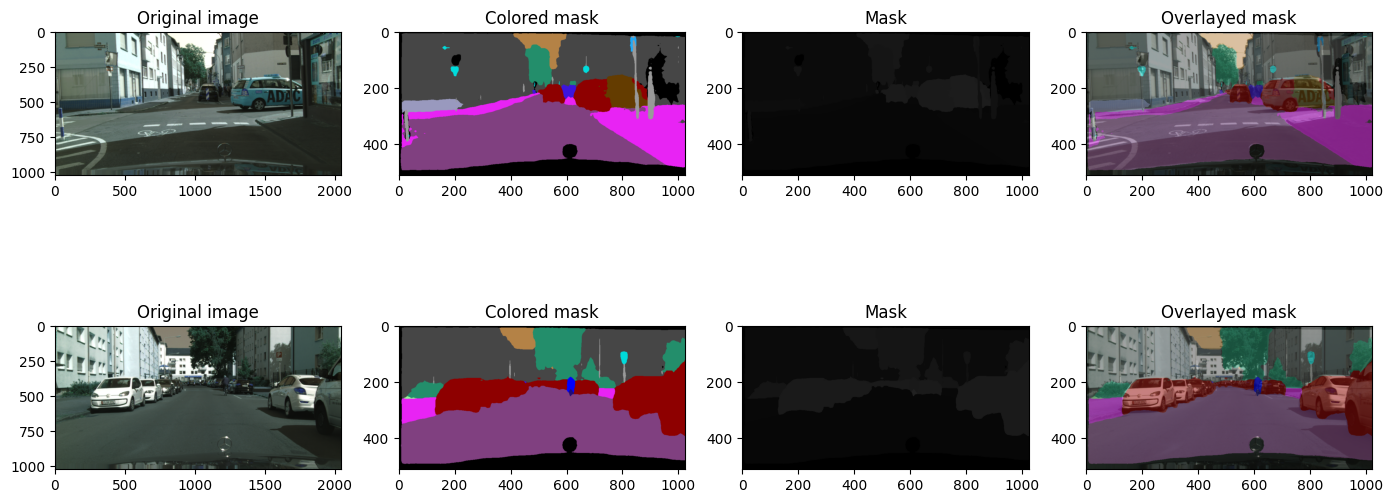

In [17]:
# Run inference using ONNX model and visualize results
onnx_imgs_list = sorted(image_list + glob.glob('onnx_results/*'))
visualize_masks(onnx_imgs_list)

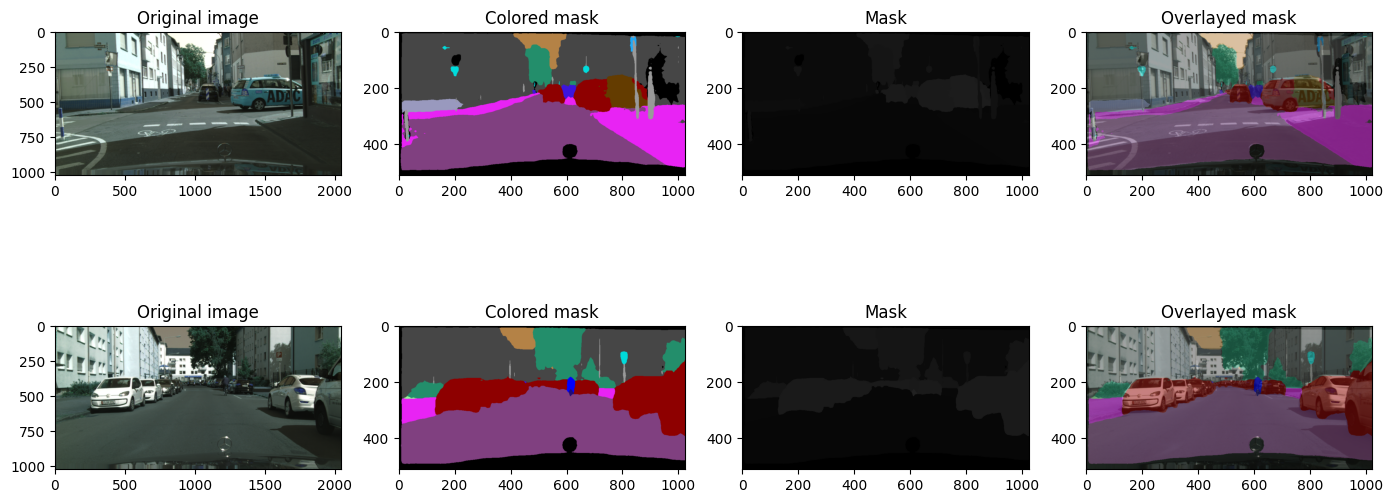

In [18]:
# Run inference using OpenVINO IR model and visualize results
ir_imgs_list = sorted(image_list + glob.glob('openvino_ir_results/*'))
visualize_masks(ir_imgs_list)

<a id='7'><a>
# Visualize the results from 3 model for comparison

Text(0.5, 1.0, 'OpenVINO IR Colored Mask')

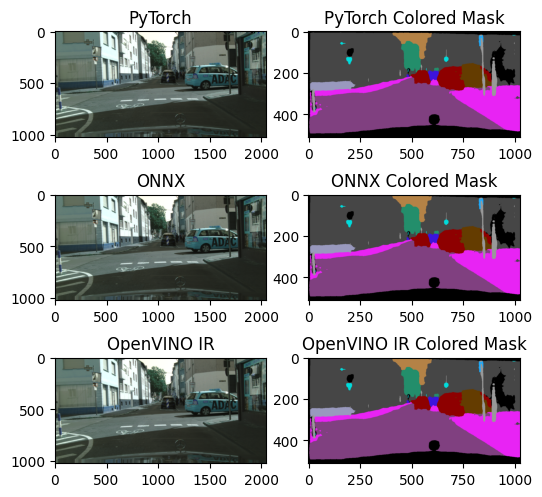

In [19]:
# You can play around with indices to visualize different images
# The title_dict in visualize_masks function shows the order of images in lists
orig_pytorch = cv2.imread(pytorch_imgs_list[0])
colored_mask_pytorch = cv2.imread(pytorch_imgs_list[2])

orig_onnx = cv2.imread(onnx_imgs_list[0])
colored_mask_onnx = cv2.imread(onnx_imgs_list[2])

orig_ir = cv2.imread(ir_imgs_list[0])
colored_mask_ir = cv2.imread(ir_imgs_list[2])

plt.rcParams['figure.figsize'] = (6,6)
plt.subplot(3,2,1)
plt.imshow(orig_pytorch)
plt.title("PyTorch")

plt.subplot(3,2,2)
plt.imshow(colored_mask_pytorch)
plt.title("PyTorch Colored Mask")

plt.subplot(3,2,3)
plt.imshow(orig_onnx)
plt.title("ONNX")

plt.subplot(3,2,4)
plt.imshow(colored_mask_onnx)
plt.title("ONNX Colored Mask")
          
plt.subplot(3,2,5)
plt.imshow(orig_ir)
plt.title("OpenVINO IR")

plt.subplot(3,2,6)
plt.imshow(colored_mask_ir)
plt.title("OpenVINO IR Colored Mask")